In [1]:
python -m pip install rlcard

     |████████████████████████████████| 268 kB 4.3 MB/s 
  Created wheel for rlcard: filename=rlcard-1.0.7-py3-none-any.whl size=325373 sha256=42115d9544cf7c5bbbd172f1036007b92af67959cc76a5bfc85cd92cd2e073d3
  Stored in directory: /root/.cache/pip/wheels/8a/90/bd/bc402a48ca90970c9a7c2c4387dcb885fdf6073ec231a605ad
Successfully built rlcard


In [2]:
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import deque
import tensorflow as tf
from tensorflow import keras
import numpy as np
import rlcard
import rlcard.agents

In [3]:
losses = []
env = rlcard.make('limit-holdem')
print(env.state_shape[0])

[72]


# **Agent Implementation**

In [40]:
#pytorch implementation
import torch
import torch.nn as nn
import torch.optim as optim

class PredictionNetwork(nn.Module):
  def __init__(self,activation = nn.Sigmoid()):
    super().__init__()
    self.first_layer = nn.Linear(in_features = env.state_shape[0][0], out_features = 8)
    self.activation = activation
    self.output_layer = nn.Linear(in_features = 8,out_features = len(env.actions))

  def forward(self, x):
    x = self.first_layer(x)
    x = self.activation(x)
    x = self.output_layer(x)
    x = self.activation(x)
    return x



class DNQ_Poker_Agent_Pytorch():
  def __init__(self,learning_rate = 0.5,discount = 0.25,loss = nn.MSELoss()):
    self.gamma = 0.95
    self.epsilon = 1.0
    self.epsilon_decay = 0.99
    self.epsilon_min = 0.001    
    self.epsilon_max = 1
    self.learning_rate = learning_rate
    self.batch_size = 25
    self.discount = discount
    self.own_memory = deque(maxlen= 256 )  #memoria agentului
    self.rounds_played = 0
    self.brain = PredictionNetwork()  #.float()
    self.optimiser = optim.Adam(params = self.brain.parameters(),lr = self.learning_rate)
    self.loss = loss

  #def update_epsilon(self):
   #   self.rounds_played = self.rounds_played+1
    #  self.epsilon = max(self.epsilon_max - (self.rounds_played * (self.epsilon_max / self.epsilon_decay)),self.epsilon_min)
    
  def play(self,state):
      if random.random() < self.epsilon:
          action = random.choice(range(len(env.actions)))
      else:
          action = np.argmax(self.brain(state).detach().numpy())
      #self.update_epsilon()
      self.rounds_played = self.rounds_played + 1
      self.epsilon = max(self.epsilon_max - (self.rounds_played * (self.epsilon_max / self.epsilon_decay)), self.epsilon_min)
      return action

  def remember(self,state,action,reward,following_state, done):
      self.own_memory.append([state, action, reward, following_state, done])

  def replay(self):
    auxiliary_batch = random.sample(self.own_memory, self.batch_size)
    instance_loss = []  
    for state,action,reward,following_state,done in auxiliary_batch:
        target = reward
        if not done:
            target = (reward+self.gamma * np.amax(self.brain(following_state)))
        Qsa = self.brain(state).gather(1, action)
        loss = self.loss(Qsa,target)
        instance_loss.append(loss)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
    if self.epsilon > self.epsilon_min:
        self.epsilon *= self.epsilon_decay
    losses.append(sum(instance_loss) / len(instance_loss))

In [67]:
from rlcard.agents import RandomAgent

TrainingAgent = RandomAgent(env.num_actions)

agentDNQtry1 = DNQ_Poker_Agent_Pytorch(learning_rate= 0.1)
env.set_agents([agentDNQtry1, TrainingAgent])

# **Game** **Logic**

In [68]:
done = False
rewards = []
def train(rounds, agentDNQ):
  for i in range(rounds):
    if i%25 == 0:
      print("Agentul a jucat" + str(i) + "partide")
    state  = torch.from_numpy(env.reset()[0]['obs']).float()
    while not env.is_over():
      action = agentDNQ.play(state)
      while action not in env.get_state(0)['legal_actions']:
        action = agentDNQ.play(state)
      env.step(action)#da state pentru urmatorul jucator
      try:
        reward = env.get_payoffs()[0] 
      except:
        reward = 0
      bot_state = env.get_state(1)
      bot_step = TrainingAgent.step(bot_state)
      next_state, done = env.get_state(0)['obs'], env.is_over()
      agentDNQ.remember(state, action, reward, next_state, done)
      if done:
        rewards.append(reward)
        break
      if agentDNQ.rounds_played < agentDNQ.batch_size:
        agentDNQ.replay()

In [70]:
train(250, agentDNQtry1)

Agentul a jucat0partide
Agentul a jucat25partide
Agentul a jucat50partide
Agentul a jucat75partide
Agentul a jucat100partide
Agentul a jucat125partide
Agentul a jucat150partide
Agentul a jucat175partide
Agentul a jucat200partide
Agentul a jucat225partide


Text(0, 0.5, 'Cumulative earnings')

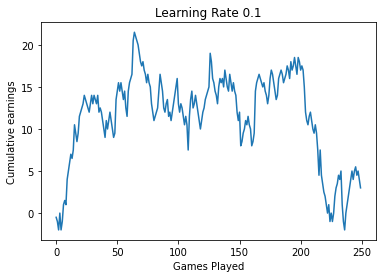

In [71]:
import matplotlib.pyplot as plt
plt.figure(0)
plt.plot([i for i in range(len(rewards))], np.cumsum(rewards))
plt.title('Learning Rate 0.1')
plt.xlabel('Games Played')
plt.ylabel('Cumulative earnings')

Agentul a jucat0partide
Agentul a jucat25partide
Agentul a jucat50partide
Agentul a jucat75partide
Agentul a jucat100partide
Agentul a jucat125partide
Agentul a jucat150partide
Agentul a jucat175partide
Agentul a jucat200partide
Agentul a jucat225partide


Text(0, 0.5, 'Cumulative earnings')

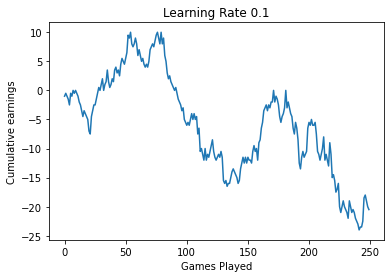

In [74]:
rewards = []
agentDNQtry2 = DNQ_Poker_Agent_Pytorch(learning_rate=0.2)
env.set_agents([agentDNQtry2, TrainingAgent])
train(250, agentDNQtry2)
plt.figure(1)
plt.plot([i for i in range(len(rewards))], np.cumsum(rewards))
plt.title('Learning Rate 0.1')
plt.xlabel('Games Played')
plt.ylabel('Cumulative earnings')

Agentul a jucat0partide
Agentul a jucat25partide
Agentul a jucat50partide
Agentul a jucat75partide
Agentul a jucat100partide
Agentul a jucat125partide
Agentul a jucat150partide
Agentul a jucat175partide
Agentul a jucat200partide
Agentul a jucat225partide


Text(0, 0.5, 'Cumulative earnings')

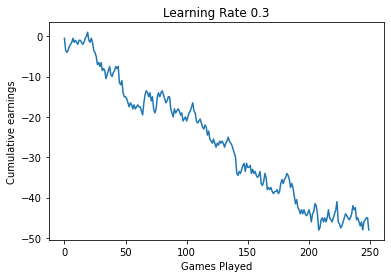

In [89]:
rewards = []
agentDNQtry3 = DNQ_Poker_Agent_Pytorch(learning_rate=0.3)
env.set_agents([agentDNQtry3, TrainingAgent])
train(250, agentDNQtry3)
plt.figure(2)
plt.plot([i for i in range(len(rewards))], np.cumsum(rewards))
plt.title('Learning Rate 0.3')
plt.xlabel('Games Played')
plt.ylabel('Cumulative earnings')

Agentul a jucat0partide
Agentul a jucat25partide
Agentul a jucat50partide
Agentul a jucat75partide
Agentul a jucat100partide
Agentul a jucat125partide
Agentul a jucat150partide
Agentul a jucat175partide
Agentul a jucat200partide
Agentul a jucat225partide


Text(0, 0.5, 'Cumulative earnings')

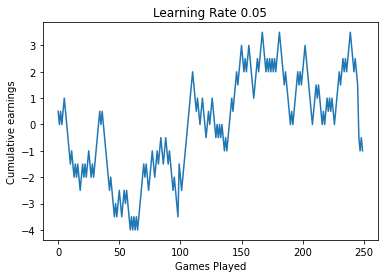

In [91]:
rewards = []
agentDNQtry4 = DNQ_Poker_Agent_Pytorch(learning_rate=0.05)
env.set_agents([agentDNQtry4, TrainingAgent])
train(250, agentDNQtry4)
plt.figure(1)
plt.plot([i for i in range(len(rewards))], np.cumsum(rewards))
plt.title('Learning Rate 0.05')
plt.xlabel('Games Played')
plt.ylabel('Cumulative earnings')

Agentul a jucat0partide
Agentul a jucat25partide
Agentul a jucat50partide
Agentul a jucat75partide
Agentul a jucat100partide
Agentul a jucat125partide
Agentul a jucat150partide
Agentul a jucat175partide
Agentul a jucat200partide
Agentul a jucat225partide


Text(0, 0.5, 'Cumulative earnings')

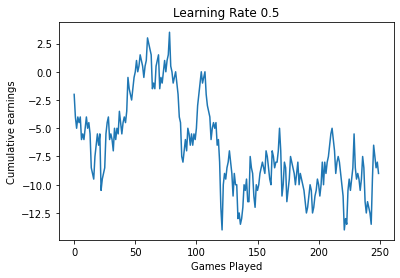

In [93]:
rewards = []
agentDNQtry5 = DNQ_Poker_Agent_Pytorch(learning_rate=0.001)
env.set_agents([agentDNQtry5, TrainingAgent])
train(250, agentDNQtry5)
plt.figure(1)
plt.plot([i for i in range(len(rewards))], np.cumsum(rewards))
plt.title('Learning Rate 0.5')
plt.xlabel('Games Played')
plt.ylabel('Cumulative earnings')

Agentul a jucat0partide
Agentul a jucat25partide
Agentul a jucat50partide
Agentul a jucat75partide
Agentul a jucat100partide
Agentul a jucat125partide
Agentul a jucat150partide
Agentul a jucat175partide
Agentul a jucat200partide
Agentul a jucat225partide


Text(0, 0.5, 'Cumulative earnings')

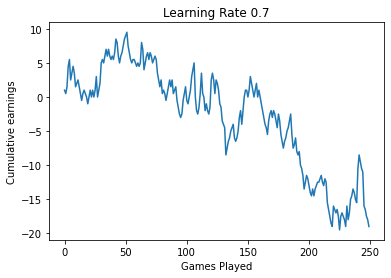

In [94]:
rewards = []
agentDNQtry6 = DNQ_Poker_Agent_Pytorch(learning_rate=0.7)
env.set_agents([agentDNQtry6, TrainingAgent])
train(250, agentDNQtry5)
plt.figure(1)
plt.plot([i for i in range(len(rewards))], np.cumsum(rewards))
plt.title('Learning Rate 0.7')
plt.xlabel('Games Played')
plt.ylabel('Cumulative earnings')

Agentul a jucat0partide
Agentul a jucat25partide
Agentul a jucat50partide
Agentul a jucat75partide
Agentul a jucat100partide
Agentul a jucat125partide
Agentul a jucat150partide
Agentul a jucat175partide
Agentul a jucat200partide
Agentul a jucat225partide


Text(0, 0.5, 'Cumulative earnings')

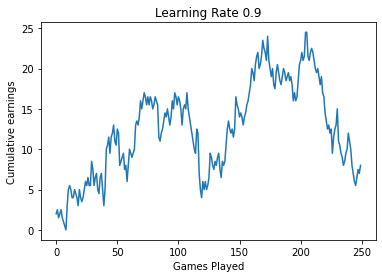

In [95]:
rewards = []
agentDNQtry7 = DNQ_Poker_Agent_Pytorch(learning_rate=0.9)
env.set_agents([agentDNQtry7, TrainingAgent])
train(250, agentDNQtry5)
plt.figure(1)
plt.plot([i for i in range(len(rewards))], np.cumsum(rewards))
plt.title('Learning Rate 0.9')
plt.xlabel('Games Played')
plt.ylabel('Cumulative earnings')